In [2]:
from bioservices import UniProt
import os
import glob
import numpy as np
import pandas as pd
import pubchempy as pcp
import time
import urllib.error
import subprocess
import requests
import shutil
import csv
import re
import xml.etree.ElementTree as ET
import openpyxl
import chardet
import json
import subprocess
import sys
import time
from time import sleep
import chardet
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import networkx as nx
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# 1 DRUG-INGREDIENS

## 1.1 提取中药组分

### 使用herbiv工具提取中药组分

In [ ]:
# 添加路径到 sys.path
sys.path.append(r'c:\users\cdzyy\appdata\roaming\python\python39\site-packages')
from herbiv import analysis



tcm, tcm_chem_links, chem, chem_protein_links, proteins = analysis.from_tcm(['柴胡', '黄芩'])
tcm
chem.head()
chem_protein_links.head()
proteins.head()

## 1.2 数据初处理

### 各数据库合并并转为csv

In [16]:

def get_encoding(file_path): # 获取文本文件的编码格式
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding'] #

def merge_files(input_folder, output_folder): # 合并文件夹中的所有文件
    for subdir, _, _ in os.walk(input_folder):
        if subdir == input_folder:
            continue

        folder_name = os.path.basename(subdir) # 获取子文件夹的名称
        output_file = os.path.join(output_folder, f"{folder_name}.csv") # 合并后的文件名
        
        files = glob.glob(f"{subdir}/*.xlsx") + glob.glob(f"{subdir}/*.txt") # 获取子文件夹中的所有文件
        combined_data = []

        for file in files: # 读取文件
            if file.endswith('.xlsx') and not os.path.basename(file).startswith('~$'): # 如果是Excel文件
                data = pd.read_excel(file, dtype=str, engine='openpyxl')
            elif file.endswith('.txt'): # 如果是文本文件
                encoding = get_encoding(file)
                data = pd.read_csv(file, sep="\t", dtype=str, encoding=encoding) # 如果文本文件使用了其他分隔符，请修改这里
            else:
                continue

            filename = os.path.splitext(os.path.basename(file))[0] # 获取文件名
            data.insert(0, 'herb_name', filename)
            combined_data.append(data)

        merged_data = pd.concat(combined_data, ignore_index=True) # 合并数据
        merged_data.to_csv(output_file, index=False, encoding='utf-8-sig') # 保存数据

input_folder = '01.Drug_Ingredients/01.ingredients_rawdata'
output_folder = '01.Drug_Ingredients/02.ingredients_preprocesseddata'
os.makedirs(output_folder, exist_ok=True) # 创建输出文件夹
merge_files(input_folder, output_folder)


## 1.3 数据添加

### HERB数据库_补充OB&DL&pubchem&smiles等

In [17]:
input_file = r"01.Drug_Ingredients\02.ingredients_preprocesseddata\02.HERB.csv"
herb_info_file = r"HERB_ingredient_info_v2.xlsx"
output_folder = r"01.Drug_Ingredients\03.ingredients_augmenteddata"

os.makedirs(output_folder, exist_ok=True)

def merge_csv_and_xlsx(input_file, herb_info_file, output_folder):
    # 读取herb_ingredient_info文件
    herb_ingredient_info = pd.read_excel(herb_info_file)
    
    # 读取输入CSV文件
    df = pd.read_csv(input_file)

    # 保留原有的 "Ingredient id" 列
    df_ingredient_ids = df['Ingredient id']

    # 仅保留在当前表格中出现的 "Ingredient_id"
    herb_ingredient_info_filtered = herb_ingredient_info[herb_ingredient_info['Ingredient_id'].isin(df_ingredient_ids)]

    # 按照 'Ingredient id' 和 'Ingredient_id' 列合并两个表格
    merged_data = df.merge(herb_ingredient_info_filtered, left_on='Ingredient id', right_on='Ingredient_id', how='left')

    # 删除重复的 'Ingredient_id' 列
    merged_data.drop(columns=['Ingredient_id'], inplace=True)

    # 将合并后的数据保存到输出文件夹中
    output_file_name = os.path.join(output_folder, "HERB_augmented.csv")
    merged_data.to_csv(output_file_name, index=False, encoding='utf-8-sig')
    print(f"Processed {os.path.basename(input_file)} and saved to {output_file_name}")

merge_csv_and_xlsx(input_file, herb_info_file, output_folder)


Processed 02.HERB.csv and saved to 01.Drug_Ingredients\03.ingredients_augmenteddata\HERB_augmented.csv


### ETCM数据库_补充PubchemCID和SMELIS 

分子全部经过AMDETlab2.0预测，但下载数据仅有QED，详细数据需单独详情页获得。故需根据"ingredient_id"AND"molecular_formula"检索获得PubchemCID和SMELIS，对于无法从pubchem获得smile的分子通过数据库2d分子结构图，手动获取smiles

In [2]:

def get_cid_and_smiles(compound_name, aliases, molecular_formula):
    try:
        # 首先使用化合物名称和分子式进行查询
        results = pcp.get_compounds(compound_name, namespace='name')
        results = [compound for compound in results if compound.molecular_formula == molecular_formula]

        if not results:
            # 如果没有结果，再使用别名进行查询
            for alias in aliases:
                results = pcp.get_compounds(alias, namespace='name')
                results = [compound for compound in results if compound.molecular_formula == molecular_formula]
                if results:
                    break

        if results:
            cid = results[0].cid
            canonical_smiles = results[0].canonical_smiles
            return cid, canonical_smiles
        else:
            return None, None
    except pcp.BadRequestError:
        print(f"BadRequestError: 检索 {compound_name} 和 {molecular_formula} 时出现错误")
        return None, None
    except Exception as e:
        print(f"检索 {compound_name} 和 {molecular_formula} 时出现错误: {e}")
        return None, None


def process_compound(index, row):
    compound_name = row['component_name_en']
    aliases = row['alias'].split('|') if isinstance(row['alias'], str) else []
    molecular_formula = row['molecular_formula']

    cid, smiles = get_cid_and_smiles(compound_name, aliases, molecular_formula)

    return index, cid, smiles

# 之后的代码保持不变
def get_file_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']


file_name = r"01.Drug_Ingredients\02.ingredients_preprocesseddata\03.ETCM.csv"

file_encoding = get_file_encoding(file_name)
df = pd.read_csv(file_name, encoding=file_encoding)

df['Pubchem_CID'] = ''
df['SMILES'] = ''

# 设置线程数，根据您的系统性能进行调整
num_threads = 20

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    results = list(executor.map(process_compound, df.index, (row for _, row in df.iterrows())))

for result in results:
    index, cid, smiles = result
    df.at[index, 'Pubchem_CID'] = cid
    df.at[index, 'SMILES'] = smiles
    print(f"Index {index}: Pubchem_CID: {cid}, SMILES: {smiles}")

output_file_name = r"01.Drug_Ingredients\03.ingredients_augmenteddata\ETCM_augmented.csv"
df.to_csv(output_file_name, index=False, encoding=file_encoding)
print(f"数据已保存到文件：{output_file_name}")

检索 (-)-(13R,19S)-7β,11α,19-trihydroxy-N-rnethyl-13-(S-2-methylbutyryloxy)-2α-propionyloxyhetisanium hy-droxide 和 C30H46NO7+ 时出现错误: identifier/cid cannot be None
检索 (-)-(13R,19S)-11α,19-dihydroxy-N-methyl-13-(S-2-methylbutyryloxy)-2α-propionyloxyhetisanium hy-droxide 和 C30H46NO6+ 时出现错误: identifier/cid cannot be None
检索 Chasmanine 和 C25H41NO6 时出现错误: 'PUGREST.ServerBusy'
检索 Beiwutinine 和 C23H37NO10 时出现错误: identifier/cid cannot be None
检索 Deltamine 和 C25H39NO7 时出现错误: identifier/cid cannot be None
检索 crassicauline A 和 C35H49NO11 时出现错误: identifier/cid cannot be None
检索 Foresticine 和 C24H39NO6 时出现错误: identifier/cid cannot be None
检索 Deoxyaconitine 和 C33H45NO10 时出现错误: identifier/cid cannot be None
检索 yokonoside 和 C20H21NO12 时出现错误: identifier/cid cannot be None
检索 (6S)-1-isopropyl-3-isopropylidene-6-methyl-6-vinylcyclohexene 和 C15H24 时出现错误: 'PUGREST.ServerBusy'
检索 [10]-Gingerdione 和 C21H32O4 时出现错误: <urlopen error [Errno 2] No such file or directory>
检索 1-(3,4-dimethoxyphenyl)-5-hydroxy-decan-3-

### HIT数据库_直接复制

分子都是基于证据，且都具有pubchemID和smiles值

In [4]:
# 定义源文件路径
source_path = "01.Drug_Ingredients/02.ingredients_preprocesseddata/01.HIT.csv"

# 定义目标文件路径
target_path = "01.Drug_Ingredients/03.ingredients_augmenteddata/HIT.csv"

# 复制文件
shutil.copy2(source_path, target_path)

# 重命名文件
os.rename(target_path, os.path.join(os.path.dirname(target_path), "HIT.csv"))

## 1.4 数据初筛

### HERB数据库_删除无Pubchem ID的行

有OB, DL, Pubchem ID, SMELIS。若无Pubchem ID的值同样没有SMELIS，并且数据库不提供分子结构图，故删除。

In [6]:
# 读取原始数据
df = pd.read_csv("01.Drug_Ingredients/03.ingredients_augmenteddata/HERB_augmented.csv")

# 删除PubChem_id列的值为空的行
df = df.dropna(subset=['PubChem_id'])

# 将处理后的数据输出到新的csv文件中

os.makedirs("01.Drug_Ingredients/04.ingredients_filtereddata", exist_ok=True)

df.to_csv("01.Drug_Ingredients/04.ingredients_filtereddata/HERB_filtered.csv", index=False)

### ETCM数据库和HIT数据库_直接复制

In [ ]:
# 源文件路径
hit_file = "01.Drug_Ingredients/03.ingredients_augmenteddata/HIT.csv"
etcm_file = "01.Drug_Ingredients/03.ingredients_preprocesseddata/ETCM_augmented.csv"

# 目标文件夹路径
target_folder = "01.Drug_Ingredients/04.ingredients_filtereddata"

# 将HIT.csv复制到目标文件夹
shutil.copy2(hit_file, target_folder)

# 将ETCM.csv复制到目标文件夹
shutil.copy2(etcm_file, target_folder)


## 1.5 ADMETlab2.0

https://admetmesh.scbdd.com/

## 1.6 二次筛选

## 1.7 多数据库文件合并

### 多数据库文件合并，veen图

In [ ]:
input_folder = r""
output_file = r""

def merge_xlsx_files(input_folder, output_file):
    xlsx_files = [file for file in glob.glob(os.path.join(input_folder, "*.xlsx")) if not file.startswith('~$')]
    print(f"Found {len(xlsx_files)} xlsx files in the input folder.")

    merged_data = pd.DataFrame()

    for xlsx_file in xlsx_files:
        data = pd.read_excel(xlsx_file)
        source = os.path.basename(xlsx_file).split('_')[0]
        data.insert(0, "Source", source)
        merged_data = pd.concat([merged_data, data], ignore_index=True)

    merged_data.to_excel(output_file, index=False)
    print(f"Merged data saved to {output_file}")

merge_xlsx_files(input_folder, output_file)

### 形成ingredients_smiles唯一值csv文件

In [3]:
input_file = r""
output_file = r""

def remove_duplicates(input_file, output_file):
    data = pd.read_excel(input_file)

    # 删除Pubchem_ID列的值重复的行，仅保留第一个
    data = data.drop_duplicates(subset=["Pubchem_CID"], keep="first")

    # 删除同时具有相同 "Ingredient name" 和 "molecular_formula" 值的行，仅保留第一个
    data = data.drop_duplicates(subset=["Ingredient name", "molecular_formula"], keep="first")

    # 保存结果到输出文件
    data.to_excel(output_file, index=False)

remove_duplicates(input_file, output_file)

### 形成中药分类下的成分唯一值，中药对应成分

In [ ]:

input_file = ""
output_file = ""

def remove_duplicates(input_file, output_file):
    data = pd.read_excel(input_file)
    # 按照source列的值分类
    grouped = data.groupby("source")
    # 在每个source小类别里，删除Pubchem_ID列的值重复的行，仅保留第一个
    for name, group in grouped:
        group = group.drop_duplicates(subset=["Pubchem_ID"], keep="first")
        # 删除同时具有相同 "Ingredient name" 和 "molecular_formula" 值的行，仅保留第一个
        group = group.drop_duplicates(subset=["Ingredient name", "molecular_formula"], keep="first")
        # 将处理后的数据添加到结果中
        if name == grouped.groups.keys()[0]:
            result = group
        else:
            result = pd.concat([result, group])
    # 保存结果到输出文件
    result.to_excel(output_file, index=False)

remove_duplicates(input_file, output_file)

### 根据名称和分子式补充CID和SMILES

## 1.4 合并去重

### 去重-得到全部无重复成分

### 去重—各中药内保留成分唯一值

# 2 INGREDIENT-TARGETS

## 2.1 靶点预测

1. 获取靶点：cmd运行代码 python targets.py --input "C:\Users\cdzyy\OneDrive - stu.cdutcm.edu.cn\Paper writing\Network pharmacology\Haoqin-qingdan\01_drug_ingredients\05.merge\no_duplicates\Ingredient_smiles.csv" --output "C:\Users\cdzyy\OneDrive - stu.cdutcm.edu.cn\Paper writing\Network pharmacology\Haoqin-qingdan\01_drug_ingredients\file.csv"
2. uniprot转换entry name


In [ ]:
!python 01_drug_ingredients/targets.py --input "C:\Users\cdzyy\OneDrive - stu.cdutcm.edu.cn\Paper writing\Network pharmacology\Haoqin-qingdan\01_drug_ingredients\05.merge\SMILES_qed0.67.csv" --output "C:\Users\cdzyy\OneDrive - stu.cdutcm.edu.cn\Paper writing\Network pharmacology\Haoqin-qingdan\01_drug_ingredients\05.merge\TARGETS_qed0.67.csv"


## 2.2 初筛_保留human

In [17]:
input_folder = '02_ingredients_targets/021_ingredients_targets_orig'
output_folder = '02_ingredients_targets/022_ingredients_targets_processed'

# 创建输出文件夹（如果不存在）
os.makedirs(output_folder, exist_ok=True)

# 获取文件夹中的所有 CSV 文件
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

for csv_file in csv_files:
    file_path = os.path.join(input_folder, csv_file)

    # 使用 chardet 自动检测编码格式
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())

    # 读取 CSV 文件
    df = pd.read_csv(file_path, index_col=None, header=0, encoding=result['encoding'])

    # 处理 UniProt_name 列
    df = df.assign(UniProt_name=df['UniProt_name'].str.split('|')).explode('UniProt_name')

    # 仅保留 UniProt_name 列中包含 *_HUMAN 的行
    df = df[df['UniProt_name'].str.contains('_HUMAN')]

    # 保存处理后的 CSV 文件，并重命名
    output_file_name = csv_file.replace('.csv', '_processed.csv')
    output_file_path = os.path.join(output_folder, output_file_name)
    
    df.to_csv(output_file_path, index=False)


## 2.3 去重保留uniprot name唯一值

In [18]:
input_folder = '02_ingredients_targets/022_ingredients_targets_processed'
output_folder = '02_ingredients_targets/023_ingredients_targets_uniquedata'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all files in the input folder
all_files = os.listdir(input_folder)

# Filter only CSV files
csv_files = [file for file in all_files if file.endswith('.csv')]

for csv_file in csv_files:
    input_file_path = os.path.join(input_folder, csv_file)
    output_file_path = os.path.join(output_folder, csv_file)

    # Detect file encoding
    with open(input_file_path, 'rb') as f:
        result = chardet.detect(f.read())

    # Read file with the detected encoding
    df = pd.read_csv(input_file_path, index_col=None, header=0, encoding=result['encoding'])

    # Drop duplicates in 'UniProt_name' column and keep only unique values
    df = df[['UniProt_name']].drop_duplicates()

    # Save the processed dataframe to a new CSV file
    output_file_path = output_file_path.replace('.csv', '_uniquedata.csv')
    df.to_csv(output_file_path, index=False)


## 2.4 核准Uniprot reviewed蛋白

In [ ]:
## unipor rest api 物种为人，状态为reviewed的蛋白质序列
url = 'https://rest.uniprot.org/uniprotkb/stream?format=fasta&query=%28%2A%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28model_organism%3A9606%29'
all_fastas = requests.get(url).text

In [80]:
input_folder = '02_ingredients_targets/023_ingredients_targets_uniquedata'
output_folder = '04.Final'
os.makedirs(output_folder, exist_ok=True)

# 更改导出文件名
base_name = os.path.basename(csv_file)
output_csv = os.path.join(output_folder, base_name.replace('_uniquedata.csv', '_adjusted.csv'))

# 通过gene name匹配fasta文件的entry name
# 读取 csv 文件
csv_files = glob.glob(os.path.join(input_folder, '*_uniquedata.csv'))
df = pd.read_csv(csv_file)
fasta_list = re.split(r'\n(?=>)', all_fastas)
# 获取 csv 表格文件中 UniProt_name 列的值列表
symbol_values = df['UniProt_name'].tolist()
# 构建正则表达式模式
pattern = '|'.join([f'\\b{symbol}\\b' for symbol in symbol_values])
# 使用正则表达式模式匹配 fasta 列表
matched_fastas = [fasta for fasta in fasta_list if re.search(pattern, fasta)]
# 创建包含 fasta 数据的 DataFrame
fasta_df = pd.DataFrame({'fasta': matched_fastas})

# 除标题行外，每行仅保留第二个“|”后和第一个空格前的内容
# 处理每行数据，提取所需内容
processed_data = []
original_values = []
for index, row in fasta_df.iterrows():
    value = row['fasta']
    value_parts = value.split('|')
    if len(value_parts) > 2:
        processed_value = value_parts[2].split(' ')[0]
        original_value = [match for match in symbol_values if match in value]
    else:
        processed_value = ''
        original_value = []
    processed_data.append(processed_value)
    original_values.append(original_value)

# 创建新的 DataFrame，并将处理后的数据存入其中
processed_df = pd.DataFrame({
    'Original Value': original_values, 
    'Processed Value': processed_data
})

# 导出为 CSV 文件
processed_df.to_csv(output_csv, index=False)
print(f"Result exported to {output_csv}")


Result exported to 04.Final/ingredient_output.csv


# 3 DISEASE-TARGETS

## 3.1 获取原始信息

### 使用DisGeNET REST API 获取DisGeNET数据库疾病靶点

In [9]:
# 设置导出文件夹路径和导出文件名
output_folder = "03_diseases_targets/031_orig"  # 路径可根据需要更改
output_filename = "disgenet_results.xml"  # 文件名可根据需要更改
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, output_filename)

# 输入疾病信息
vocabulary = "mesh" # ICD9CM, ICD10, MeSH, OMIM, DO, EFO, NCI, HPO, MONDO, or ORDO identifier
disease_id = "D001172" # Disease id or list of disease ids separated by "," up to 100.

# 设置API密钥
token = "1e0082cbe4be2f5cc81b1b9c8876d8a577cfd697" # 请替换为你已获得授权的DisGeNET_REST_API密钥
headers = {"Authorization": f"Bearer {token}"}

# 发送请求，获取GDA数据
url = f"https://www.disgenet.org/api/gda/disease/{vocabulary}/{disease_id}?format=xml"  # 共有三种格式：TSV, JSON, XML
response = requests.get(url, headers=headers)

# 如果文件夹不存在则创建
os.makedirs(output_folder, exist_ok=True)

# 输出结果到文件
with open(output_file, "w", encoding="utf-8") as f:
    f.write(response.text)
    
print(f"结果已保存至文件：{output_file}")


结果已保存至文件：01.orig/disgenet_results.xml


## 3.2 数据初处理

### DisGeNET数据库xml转csv

In [13]:
# 检查目录是否存在，如果不存在，则创建它
output_dir = '03_diseases_targets/032_trans'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 解析XML文件
tree = ET.parse('03_diseases_targets/031_orig/disgenet_results.xml')
root = tree.getroot()

# 打开CSV文件并写入标题行
with open(os.path.join(output_dir, 'disgenet_results.csv'), 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['geneid', 'gene_symbol', 'uniprotid', 'gene_dsi', 'gene_dpi', 'gene_pli', 'protein_class', 'protein_class_name', 'diseaseid', 'disease_name', 'disease_class', 'disease_class_name', 'disease_type', 'disease_semantic_type', 'score', 'ei', 'el', 'year_initial', 'year_final', 'source'])

    # 遍历XML文件并将值写入CSV文件
    for item in root.findall('.//list-item'):
        geneid = item.find('geneid').text
        gene_symbol = item.find('gene_symbol').text
        uniprotid = item.find('uniprotid').text
        gene_dsi = item.find('gene_dsi').text
        gene_dpi = item.find('gene_dpi').text
        gene_pli = item.find('gene_pli').text
        protein_class = item.find('protein_class').text
        protein_class_name = item.find('protein_class_name').text
        diseaseid = item.find('diseaseid').text
        disease_name = item.find('disease_name').text
        disease_class = item.find('disease_class').text
        disease_class_name = item.find('disease_class_name').text
        disease_type = item.find('disease_type').text
        disease_semantic_type = item.find('disease_semantic_type').text
        score = item.find('score').text
        ei = item.find('ei').text
        el = item.find('el').text
        year_initial = item.find('year_initial').text
        year_final = item.find('year_final').text
        source = item.find('source').text

        # 将值写入CSV文件
        writer.writerow([geneid, gene_symbol, uniprotid, gene_dsi, gene_dpi, gene_pli, protein_class, protein_class_name, diseaseid, disease_name, disease_class, disease_class_name, disease_type, disease_semantic_type, score, ei, el, year_initial, year_final, source])


### 其他tsv, txt转csv

In [15]:
# 输入文件夹路径
input_folder = "03_diseases_targets/031_orig"
output_folder = "03_diseases_targets/032_trans"

# 创建输出文件夹
os.makedirs(output_folder, exist_ok=True)

# 遍历所有文件
for file in os.listdir(input_folder):
    if file.endswith('.tsv') or file.endswith('.txt'):
        # 读取tsv文件内容
        with open(os.path.join(input_folder, file), 'r', encoding='utf-8') as f:
            tsv_reader = csv.reader(f, delimiter='\t')
            rows = [row for row in tsv_reader]

        # 将tsv文件内容写入csv文件
        with open(os.path.join(output_folder, file.replace('.tsv', '.csv').replace('.txt', '.csv')), 'w', newline='', encoding='utf-8') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerows(rows)
    elif file.endswith('.csv'):
        # 直接复制csv文件到输出文件夹
        shutil.copyfile(os.path.join(input_folder, file), os.path.join(output_folder, file))
    elif file.endswith('.xlsx'):
        # 读取xlsx文件
        df = pd.read_excel(os.path.join(input_folder, file))

        # 将xlsx文件内容写入csv文件
        csv_file = os.path.join(output_folder, file.replace('.xlsx', '.csv'))
        df.to_csv(csv_file, index=False, encoding='utf-8')

## 3.3 疾病靶点筛选

In [16]:
input_folder = '03_diseases_targets/032_trans'
output_folder = '03_diseases_targets/033_screened'

os.makedirs(output_folder, exist_ok=True)

## 以下为筛选条件
CTD_inferencescore_threshold = 100 # 文件名含有“CTD”的文件筛选条件
disgenet_score_threshold = 0.1 # 文件名含有“disgenet”的文件筛选条件
GeneCards_Relevancescore_threshold = 10 # 文件名含有“GeneCards”的文件筛选条件
NCBI_org_name = "Homo sapiens" # 文件名含有“NCBI”的文件筛选条件
Opentargets_overallAssociationScore_threshold = 0.1 # 文件名含有“Opentargets”的文件筛选条件

for file in os.listdir(input_folder):
    if file.endswith('.csv') and 'CTD' in file:
        output_file = os.path.join(output_folder, file)
        with open(os.path.join(input_folder, file), 'r', newline='', encoding='utf-8') as f_input:
            with open(output_file, 'w', newline='', encoding='utf-8') as f_output:
                reader = csv.reader(f_input)
                writer = csv.writer(f_output)
                header = next(reader)
                writer.writerow(header)
                
                direct_evidence_index = header.index("Direct Evidence")
                inference_score_index = header.index("Inference Score")
                
                for row in reader:
                    if row[direct_evidence_index] != "": 
                        writer.writerow(row)
                    elif float(row[inference_score_index]) >= CTD_inferencescore_threshold: 
                        writer.writerow(row)
                        
    elif file.endswith('.csv') and 'disgenet' in file:
        output_file = os.path.join(output_folder, file)
        with open(os.path.join(input_folder, file), 'r', newline='', encoding='utf-8') as f_input:
            with open(output_file, 'w', newline='', encoding='utf-8') as f_output:
                reader = csv.reader(f_input)
                writer = csv.writer(f_output)
                header = next(reader)
                writer.writerow(header)
                
                score_index = header.index("score")
                
                for row in reader:
                    if float(row[score_index]) >= disgenet_score_threshold: 
                        writer.writerow(row)
                        
    elif file.endswith('.csv') and 'GeneCards' in file:
        output_file = os.path.join(output_folder, file)
        with open(os.path.join(input_folder, file), 'r', newline='', encoding='utf-8') as f_input:
            with open(output_file, 'w', newline='', encoding='utf-8') as f_output:
                reader = csv.reader(f_input)
                writer = csv.writer(f_output)
                header = next(reader)
                writer.writerow(header)
                
                relevance_score_index = header.index("Relevance score")
                
                for row in reader:
                    if float(row[relevance_score_index]) >= GeneCards_Relevancescore_threshold: 
                        writer.writerow(row)
                        
    elif file.endswith('.csv') and 'NCBI' in file:
        output_file = os.path.join(output_folder, file)
        with open(os.path.join(input_folder, file), 'r', newline='', encoding='utf-8') as f_input:
            with open(output_file, 'w', newline='', encoding='utf-8') as f_output:
                reader = csv.reader(f_input)
                writer = csv.writer(f_output)
                header = next(reader)
                writer.writerow(header)
                
                org_name_index = header.index("Org_name")
                
                for row in reader:
                    if row[org_name_index] == NCBI_org_name: 
                        writer.writerow(row)

for file in os.listdir(input_folder):
    if file.endswith('.csv') and 'Opentargets' in file:
        output_file = os.path.join(output_folder, file)
        with open(os.path.join(input_folder, file), 'r', newline='', encoding='utf-8') as f_input:
            with open(output_file, 'w', newline='', encoding='utf-8') as f_output:
                reader = csv.reader(f_input)
                writer = csv.writer(f_output)
                header = next(reader)
                writer.writerow(header)
                
                overall_score_index = header.index("overallAssociationScore")
                
                for row in reader:
                    if float(row[overall_score_index]) >= Opentargets_overallAssociationScore_threshold:
                        writer.writerow(row)
    elif file.endswith('.csv') and 'OMIM' in file:
        output_file = os.path.join(output_folder, file)
        shutil.copyfile(os.path.join(input_folder, file), output_file)

## 3.4 疾病靶点合并并去重

In [45]:
# 定义输入输出文件夹路径
input_folder = '03_diseases_targets/033_screened'
output_folder = '03_diseases_targets/033_uniquedata'

# 创建输出文件夹
os.makedirs(output_folder, exist_ok=True)

# 创建一个空列表，用于存储所有含有“symbol”列的值
all_symbol_values = []

# 遍历所有CSV文件
for file in os.listdir(input_folder):
    if file.endswith('.csv'):
        # 读取CSV文件内容
        with open(os.path.join(input_folder, file), 'r', encoding='utf-8') as f:
            csv_reader = csv.reader(f)
            header = next(csv_reader)
            symbol_columns = [i for i, col in enumerate(header) if 'symbol' in col.lower()]
            # 如果CSV文件中存在含有“symbol”列
            if symbol_columns:
                # 遍历所有行
                for row in csv_reader:
                    # 将含有“symbol”列的值添加到all_symbol_values列表中
                    for col_index in symbol_columns:
                        all_symbol_values.append(row[col_index])

# 将all_symbol_values列表去重，仅保留唯一值
unique_symbol_values = list(set(all_symbol_values))

# 将所有唯一值合并为一个长字符串
merged_values = ', '.join(unique_symbol_values)

# 将合并后的值写入到输出文件中
output_file = os.path.join(output_folder, 'disease_targets_uniquedata.csv')
with open(output_file, 'w', newline='', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(['Symbol'])
    for symbol in merged_values.split(','):
        csv_writer.writerow([symbol.strip()])

# 4 Uniprot 基因entry name 核对

#### uniprot api url

In [60]:
## unipor rest api 物种为人，状态为reviewed的蛋白质序列
url = 'https://rest.uniprot.org/uniprotkb/stream?format=fasta&query=%28%2A%29%20AND%20%28reviewed%3Atrue%29%20AND%20%28model_organism%3A9606%29'
all_fastas = requests.get(url).text


#### 测试

In [ ]:
import re
fasta_list = re.split(r'\n(?=>)', all_fastas)
[fasta for fasta in fasta_list if 'DUS3_HUMAN' in fasta]


## 4.1 成分靶点校正

In [ ]:
input_folder = '02_ingredients_targets/023_ingredients_targets_uniquedata'
output_folder = '04_intersection_targets'
os.makedirs(output_folder, exist_ok=True)

# 更改导出文件名
base_name = os.path.basename(csv_file)
output_csv = os.path.join(output_folder, base_name.replace('_uniquedata.csv', '_adjusted.csv'))

# 通过gene name匹配fasta文件的entry name
# 读取 csv 文件
csv_files = glob.glob(os.path.join(input_folder, '*_uniquedata.csv'))
df = pd.read_csv(csv_file)
fasta_list = re.split(r'\n(?=>)', all_fastas)
# 获取 csv 表格文件中 UniProt_name 列的值列表
symbol_values = df['UniProt_name'].tolist()
# 构建正则表达式模式
pattern = '|'.join([f'\\b{symbol}\\b' for symbol in symbol_values])
# 使用正则表达式模式匹配 fasta 列表
matched_fastas = [fasta for fasta in fasta_list if re.search(pattern, fasta)]
# 创建包含 fasta 数据的 DataFrame
fasta_df = pd.DataFrame({'fasta': matched_fastas})

# 除标题行外，每行仅保留第二个“|”后和第一个空格前的内容
# 处理每行数据，提取所需内容
processed_data = []
original_values = []
for index, row in fasta_df.iterrows():
    value = row['fasta']
    value_parts = value.split('|')
    if len(value_parts) > 2:
        processed_value = value_parts[2].split(' ')[0]
        original_value = [match for match in symbol_values if match in value]
    else:
        processed_value = ''
        original_value = []
    processed_data.append(processed_value)
    original_values.append(original_value)

# 创建新的 DataFrame，并将处理后的数据存入其中
processed_df = pd.DataFrame({
    'Original Value': original_values, 
    'Processed Value': processed_data
})

# 导出为 CSV 文件
processed_df.to_csv(output_csv, index=False)
print(f"Result exported to {output_csv}")

## 4.2 疾病靶点校正

In [71]:
csv_file = '03_diseases_targets/033_uniquedata/disease_targets_uniquedata.csv'
output_csv = '04_intersection_targets/disease_targets_adjusted.csv'

# 通过gene name匹配fasta文件的entry name
# 读取 csv 文件
df = pd.read_csv(csv_file)
fasta_list = re.split(r'\n(?=>)', all_fastas)
# 获取 csv 表格文件中 symbol 列的值列表
symbol_values = df['Symbol'].tolist()
# 构建正则表达式模式
pattern = '|'.join([f'GN={symbol} ' for symbol in symbol_values])

# 使用正则表达式模式匹配 fasta 列表
matched_fastas = []
matched_symbols = []
for fasta in fasta_list:
    match = re.search(pattern, fasta)
    if match:
        symbol = match.group().split('=')[1]  # 获取匹配到的gene symbol
        matched_fastas.append(fasta)
        matched_symbols.append(symbol)

# 创建包含 fasta 数据的 DataFrame
fasta_df = pd.DataFrame({'fasta': matched_fastas, 'Symbol': matched_symbols})

# 除标题行外，每行仅保留第二个“|”后和第一个空格前的内容
# 处理每行数据，提取所需内容
processed_data = []
for index, row in fasta_df.iterrows():
    value = row['fasta']
    value_parts = value.split('|')
    if len(value_parts) > 2:
        processed_value = value_parts[2].split(' ')[0]
    else:
        processed_value = ''
    processed_data.append(processed_value)

# 创建新的 DataFrame，并将处理后的数据和匹配到的gene symbol存入其中
processed_df = pd.DataFrame({
    'Original Gene Symbol': fasta_df['Symbol'],
    'Processed Value': processed_data
})

# 导出为 CSV 文件
processed_df.to_csv(output_csv, index=False)
print(f"Result exported to {output_csv}")


Result exported to 04.Final/output.csv


## 4.3 成分疾病靶点

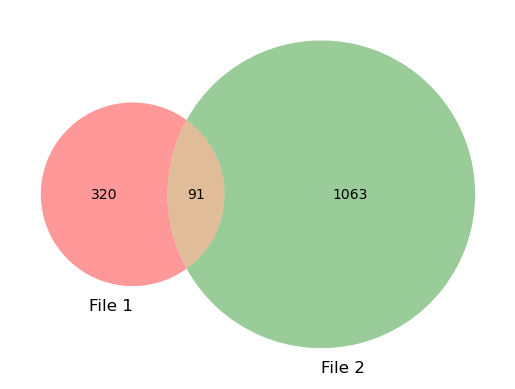

In [3]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

path = '04_intersection_targets'
output_path = '04_intersection_targets'
csv_files = glob.glob(os.path.join(path, '*.csv'))

uni_sets = []

for csv_file in csv_files:
    encoding = detect_encoding(csv_file)
    df = pd.read_csv(csv_file, encoding=encoding)
    uni_set = set(df['Processed Value'])
    uni_sets.append(uni_set)

intersection = set.intersection(*uni_sets)
result_df = pd.DataFrame(list(intersection), columns=['Processed Value'])
result_df.to_csv(os.path.join(output_path, 'intersection_targets.csv'), index=False)

# 绘制 Venn 图（仅适用于 2 个 CSV 文件的情况）
if len(uni_sets) == 2:
    venn = venn2([uni_sets[0], uni_sets[1]], set_labels=['File 1', 'File 2'])
    plt.savefig(os.path.join(output_path, 'venn_diagram.svg'), format='svg')
    plt.show()
else:
    print("Venn diagram can only be plotted for 2 CSV files.")

# 5 BIOINFORMATICS ANALYSIS

## 5.1 STRING PPI

### STRING PPI 图SVG

In [4]:
output_folder = "05_ppi" # 定义输出文件夹路径
os.makedirs(output_folder, exist_ok=True)

string_api_url = "https://version-11-5.string-db.org/api"
output_format = "svg"
method = "network"

df = pd.read_csv("04_intersection_targets/intersection_targets.csv") # 读取 CSV 文件
my_genes = df["Processed Value"].tolist()

identifiers = "%0d".join(my_genes)

request_url = "/".join([string_api_url, output_format, method])

params = {
    "identifiers": identifiers,
    "species": 9606,
    "required_score": 900,  #对应STRING网页中的"Minimum required interaction score"，可选400，700，900
    "hide_disconnected_nodes": 1,
    "caller_identity": "www.my_app.org"
}

response = requests.post(request_url, data=params)

file_name = "all_genes_network.svg"
output_path = os.path.join(output_folder, file_name)
print(f"Saving interaction network to {output_path}")

with open(output_path, 'wb') as fh:
    fh.write(response.content)

sleep(1)

Saving interaction network to output\all_genes_network.svg


### STRING TSV

In [6]:
output_folder = "05_ppi" # 请根据实际情况修改输出文件夹路径
os.makedirs(output_folder, exist_ok=True)

string_api_url = "https://string-db.org/api"
output_format = "tsv"
method = "network"

csv_file_path = "04_intersection_targets/intersection_targets.csv"  # 请根据实际情况修改 CSV 文件路径
df = pd.read_csv(csv_file_path)
my_genes = df["Processed Value"].tolist()

request_url = "/".join([string_api_url, output_format, method])

params = {
    "identifiers": "%0d".join(my_genes),
    "species": 9606,
    "required_score": 900, #对应STRING网页中的"Minimum required interaction score"，可选400，700，900
    "caller_identity": "www.my_example_app.org",
}

response = requests.post(request_url, data=params)


# 保存为 TSV 文件
output_file_path = os.path.join(output_folder, "protein_interactions.tsv")
with open(output_file_path, "w") as f:
    f.write(response.text)

print(f"Protein interactions saved to {output_file_path}")

Protein interactions saved to output\protein_interactions.tsv


## 5.2 python的networkx包_网络拓扑分析 the network topology properties

In [7]:
ppi_data = pd.read_csv("05_ppi/protein_interactions.tsv", sep="\t")
output_folder = "05_ppi"
os.makedirs(output_folder, exist_ok=True)
# 创建一个空的无向加权网络
G = nx.Graph()

# 添加节点和边
for index, row in ppi_data.iterrows():
    G.add_edge(row["preferredName_A"], row["preferredName_B"], weight=row["score"])

# 计算网络指标
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# 将所有中心性指标组合成一个DataFrame
centrality_measures = {
    'degree': degree_centrality,
    'closeness': closeness_centrality,
    'betweenness': betweenness_centrality,
    'eigenvector': eigenvector_centrality
}

df = pd.DataFrame(centrality_measures)

# 计算总和并按总和排序
df['sum'] = df.sum(axis=1)
df = df.sort_values('sum', ascending=False)

# 将结果保存为 CSV 文件
df.to_csv(f"{output_folder}/centrality_measures.csv")

### Cytoscape_图

# 6 富集分析 Enrichment Analysis

## 6.1 准备数据

In [9]:
# 读取CSV文件
output_folder = "05_ppi"
csv_file = "05_ppi/centrality_measures.csv"
df = pd.read_csv(csv_file)

# 只保留Protein列
# df = df[["Protein"]]
df = df.iloc[:, 0:1]

# 只保留前20个值
df = df.head(20)

os.makedirs(output_folder, exist_ok=True)

# 导出为XLSX文件
output_file = output_folder + "selected_proteins.xlsx"
df.to_excel(output_file, index=False)

## 6.2 R语言处理准备

In [1]:
library(openxlsx)#读取.xlsx文件
library(ggplot2)#柱状图和点状图
library(stringr)#基因ID转换
library(enrichplot)#GO,KEGG,GSEA
library(clusterProfiler)#GO,KEGG,GSEA
library(GOplot)#弦图，弦表图，系统聚类图
library(DOSE)
library(ggnewscale)
library(topGO)#绘制通路网络图
library(circlize)#绘制富集分析圈图
library(ComplexHeatmap)#绘制图例
library(repr)

Warning message:
"package 'openxlsx' was built under R version 4.2.3"


Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'enrichplot' was built under R version 4.2.3"


clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:stats':

    filter


Warning message:
"package 'GOplot' was built under R version 4.2.3"
Loading required package: ggdendro

Warning message:
"package 'ggdendro' was built under R version 4.2.3"
Loading required package: gridExtra

Warning message:
"package 'gridExtra' was built under R version 4.2.3"
Loading required package: RColo

### 读取gene name数据

In [8]:
#载入差异表达数据，只需基因ID(GO,KEGG,GSEA需要)和Log2FoldChange(GSEA需要)即可
info <- read.xlsx( "05.ppiselected_proteins.xlsx", rowNames = F,colNames = T)
print(info)
#指定富集分析的物种库
GO_database <- 'org.Hs.eg.db' #GO分析指定物种，物种缩写索引表详见http://bioconductor.org/packages/release/BiocViews.html#___OrgDb
KEGG_database <- 'hsa' #KEGG分析指定物种，物种缩写索引表详见http://www.genome.jp/kegg/catalog/org_list.html

#gene ID转换
gene <- bitr(info$'Unnamed:.0',fromType = 'SYMBOL',toType = 'ENTREZID',OrgDb = GO_database)
print(gene) 

   Unnamed:.0
1       STAT3
2        RELA
3        ESR1
4       MAPK1
5      PTPN11
6         JUN
7       HIF1A
8       NFKB1
9       HDAC1
10        FOS
11       TLR4
12     CXCL12
13       JAK1
14       JAK3
15      CXCR4
16      PRKCD
17       MTOR
18      PTPN2
19       CHUK
20       NOS3


'select()' returned 1:1 mapping between keys and columns



   SYMBOL ENTREZID
1   STAT3     6774
2    RELA     5970
3    ESR1     2099
4   MAPK1     5594
5  PTPN11     5781
6     JUN     3725
7   HIF1A     3091
8   NFKB1     4790
9   HDAC1     3065
10    FOS     2353
11   TLR4     7099
12 CXCL12     6387
13   JAK1     3716
14   JAK3     3718
15  CXCR4     7852
16  PRKCD     5580
17   MTOR     2475
18  PTPN2     5771
19   CHUK     1147
20   NOS3     4846


## 6.3 GO分析

In [9]:
#设置导出文件夹路径
output_dir <- "06_enrichment"
#如果文件夹不存在，则创建
if (!dir.exists(output_dir)) {
  dir.create(output_dir)
}
#进行GO富集分析
GO <- enrichGO(gene$ENTREZID,
               OrgDb = GO_database,
               keyType = "ENTREZID",
               ont = "ALL",
               pvalueCutoff = 0.05,
               qvalueCutoff = 0.05,
               readable = TRUE)
print(GO)
#将结果保存为CSV文件
output_file <- file.path(output_dir, "GO_enrichment_results.csv")
write.csv(GO, file = output_file)

#
# over-representation test
#
#...@organism 	 Homo sapiens 
#...@ontology 	 GOALL 
#...@keytype 	 ENTREZID 
#...@gene 	 chr [1:20] "6774" "5970" "2099" "5594" "5781" "3725" "3091" "4790" "3065" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...1060 enriched terms found
'data.frame':	1060 obs. of  10 variables:
 $ ONTOLOGY   : chr  "BP" "BP" "BP" "BP" ...
 $ ID         : chr  "GO:0043434" "GO:0062197" "GO:1901653" "GO:0034599" ...
 $ Description: chr  "response to peptide hormone" "cellular response to chemical stress" "cellular response to peptide" "cellular response to oxidative stress" ...
 $ GeneRatio  : chr  "11/20" "10/20" "10/20" "9/20" ...
 $ BgRatio    : chr  "421/18903" "345/18903" "373/18903" "288/18903" ...
 $ pvalue     : num  8.24e-14 5.66e-13 1.23e-12 5.66e-12 9.75e-12 ...
 $ p.adjust   : num  1.63e-10 5.61e-10 8.13e-10 2.81e-09 3.87e-09 ...
 $ qvalue     : num  5.93e-11 2.04e-10 2.95e-10 1.02e-09 1.40e-09 ...
 $ geneID     : chr  "STAT3/RELA/PTPN11/NFKB1/FOS/CXCL1

## 6.4 KEGG分析

In [10]:
# 设置导出文件夹路径
output_dir <- "06_enrichment"


KEGG<-enrichKEGG(gene$ENTREZID,#KEGG富集分析
                 organism = KEGG_database,
                 pvalueCutoff = 0.05,
                 qvalueCutoff = 0.05)
print(KEGG)
# 将结果保存为CSV文件
output_file <- file.path(output_dir, "KEGG_enrichment_results.csv")
write.csv(KEGG, file = output_file)

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Warning message in utils::download.file(url, quiet = TRUE, method = method, ...):
"the 'wininet' method is deprecated for http:// and https:// URLs"
Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

Warning message in utils::download.file(url, quiet = TRUE, method = method, ...):
"the 'wininet' method is deprecated for http:// and https:// URLs"


#
# over-representation test
#
#...@organism 	 hsa 
#...@ontology 	 KEGG 
#...@keytype 	 kegg 
#...@gene 	 chr [1:20] "6774" "5970" "2099" "5594" "5781" "3725" "3091" "4790" "3065" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...115 enriched terms found
'data.frame':	115 obs. of  9 variables:
 $ ID         : chr  "hsa05235" "hsa04659" "hsa05161" "hsa05167" ...
 $ Description: chr  "PD-L1 expression and PD-1 checkpoint pathway in cancer" "Th17 cell differentiation" "Hepatitis B" "Kaposi sarcoma-associated herpesvirus infection" ...
 $ GeneRatio  : chr  "12/20" "11/20" "10/20" "10/20" ...
 $ BgRatio    : chr  "89/8521" "108/8521" "162/8521" "194/8521" ...
 $ pvalue     : num  9.21e-20 1.23e-16 7.33e-13 4.50e-12 8.52e-12 ...
 $ p.adjust   : num  1.55e-17 1.03e-14 4.10e-11 1.89e-10 2.86e-10 ...
 $ qvalue     : num  4.75e-18 3.18e-15 1.26e-11 5.81e-11 8.79e-11 ...
 $ geneID     : chr  "6774/5970/5594/5781/3725/3091/4790/2353/7099/3716/2475/1147" "6774/5970/5594/3725/3091/4790/2353/3

## 6.4 富集分析可视化

In [11]:
#使用options()函数设置图像宽度和高度（以像素为单位），设置会影响Jupyter Notebook中所有后续的R图形
options(repr.plot.width = 10, repr.plot.height = 10)  # 设置宽度为10英寸，高度为6英寸

### 可视化_柱状图、点状图

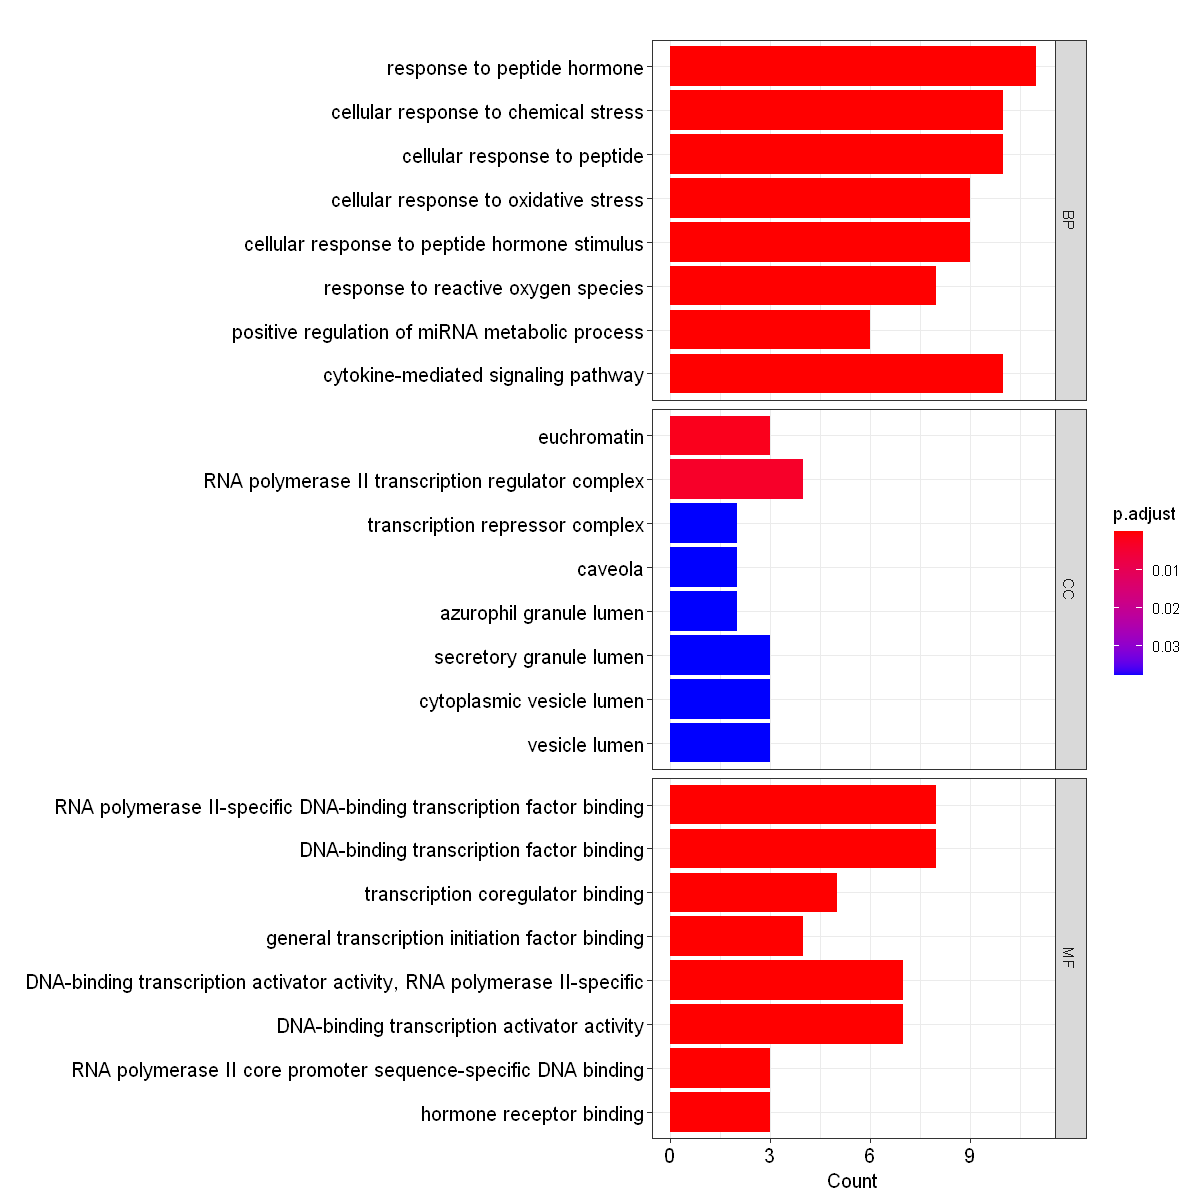

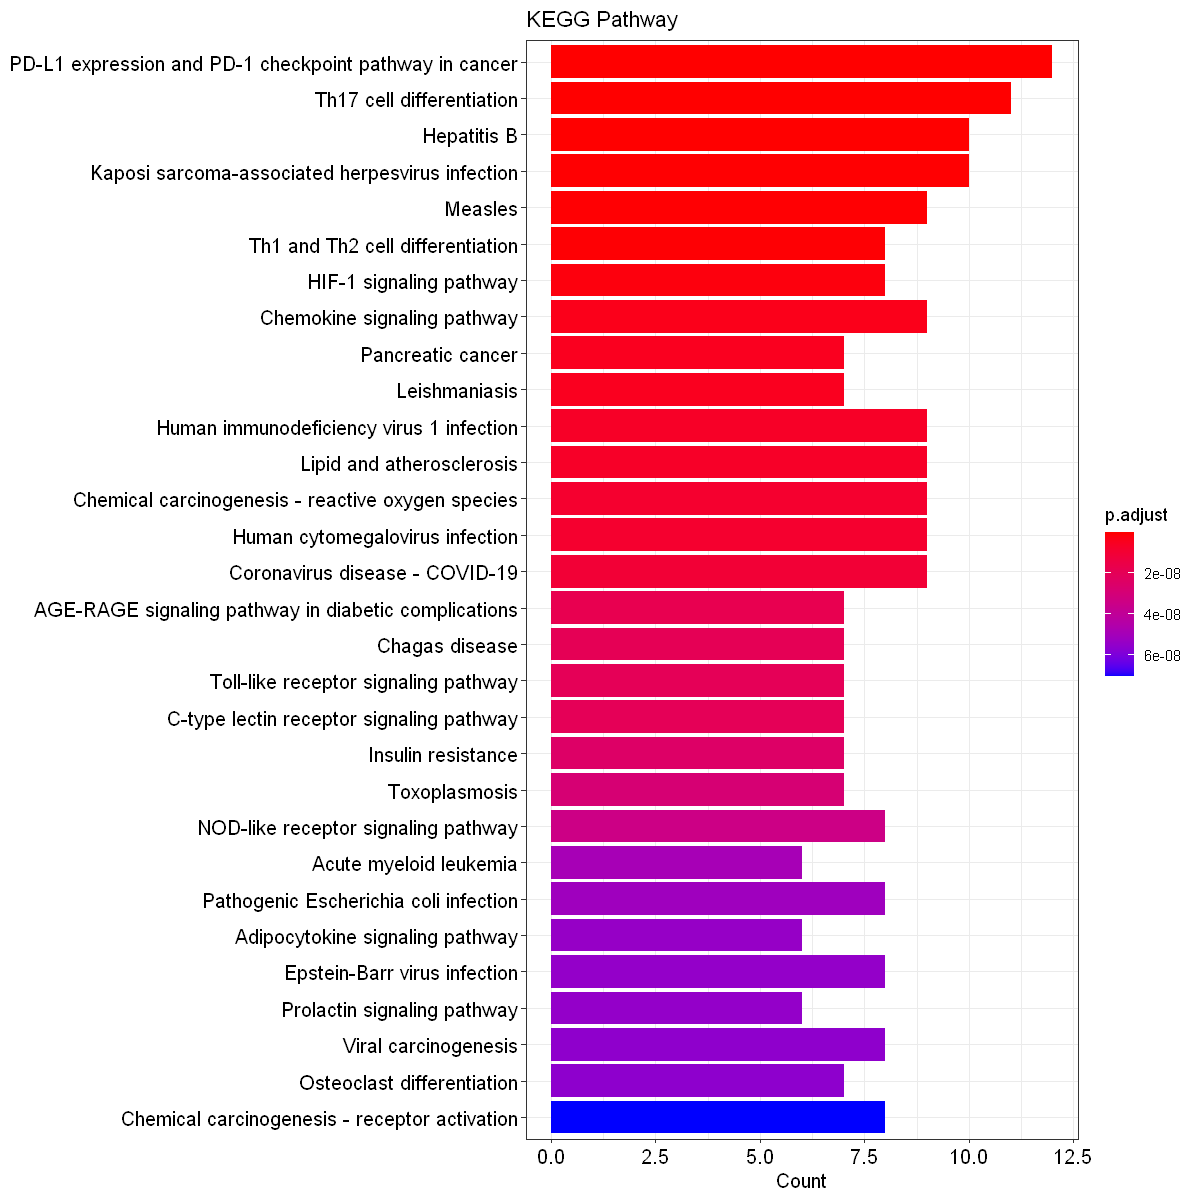

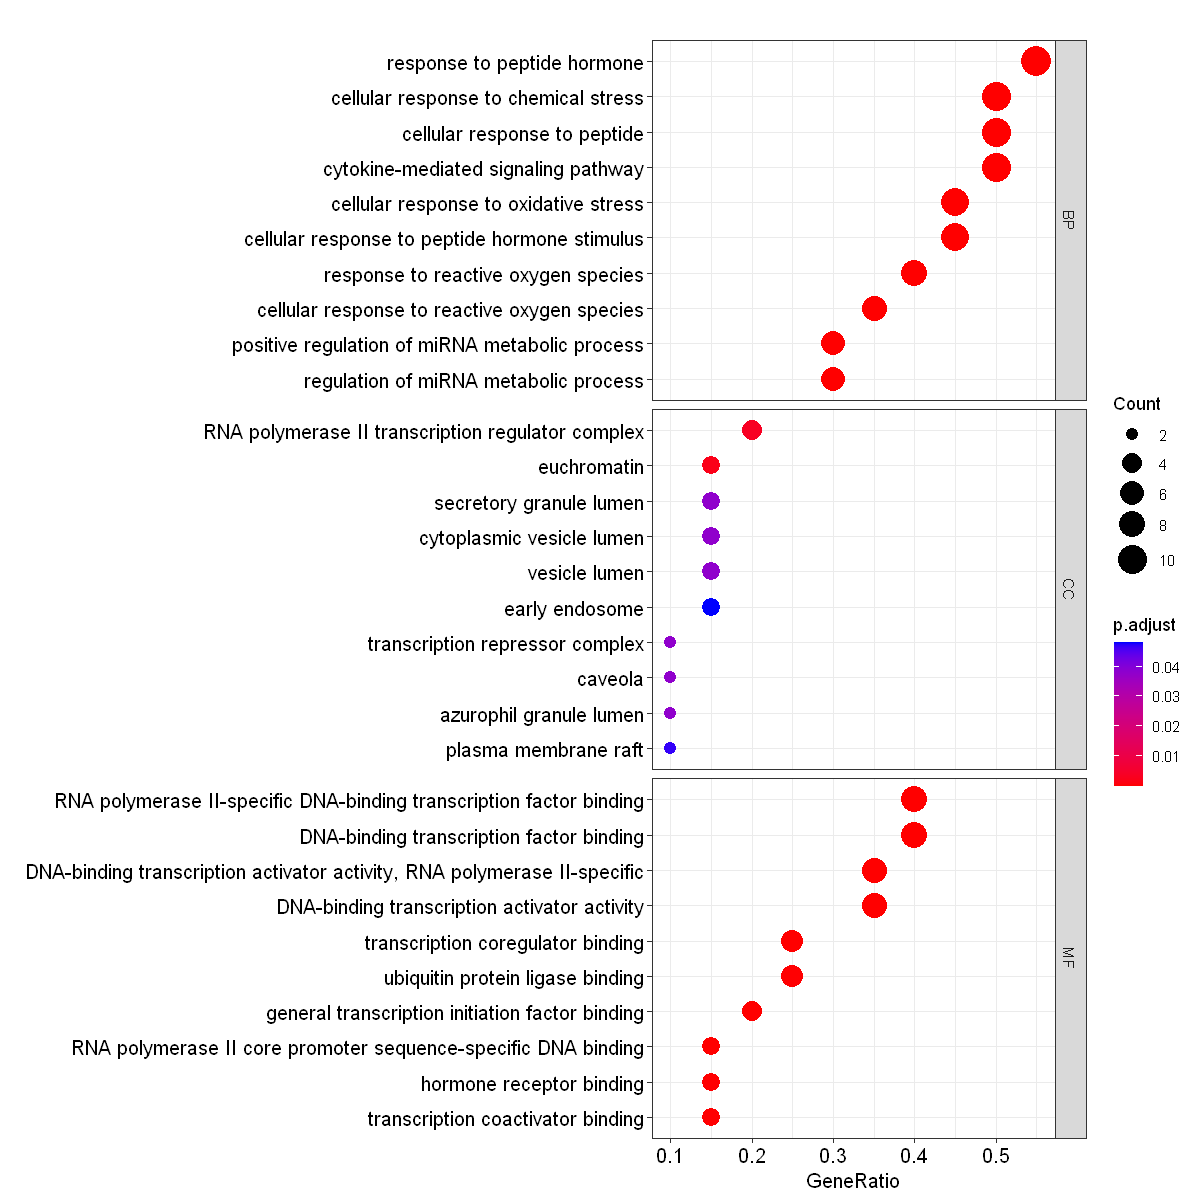

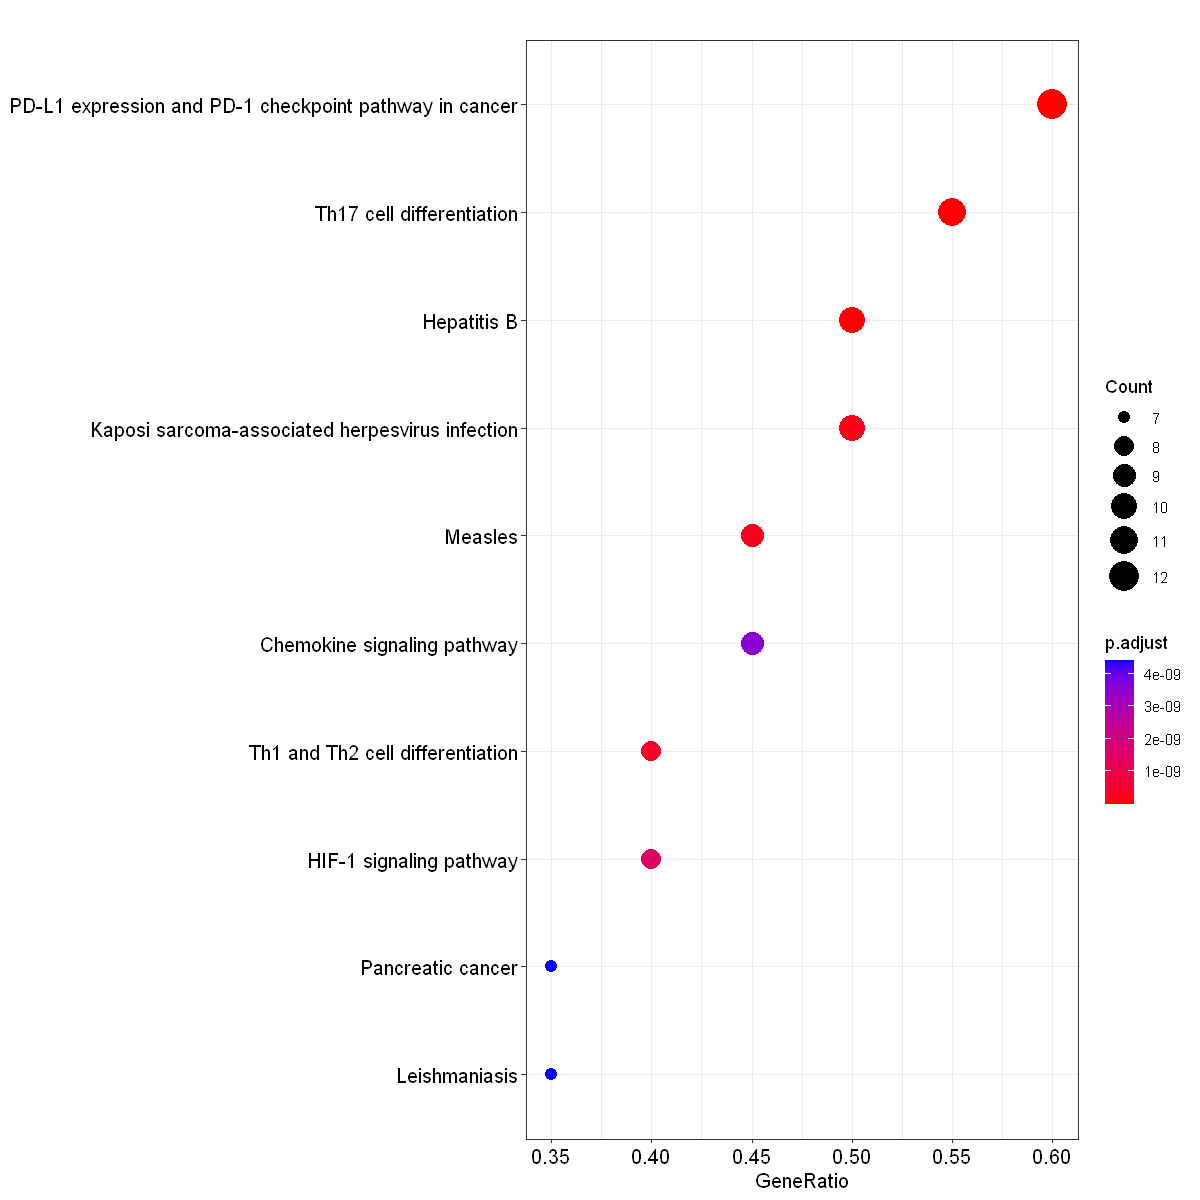

In [12]:
#label_format=150表示标签长度为150，即每行显示150个字符，避免自动换行
p1 <- barplot(GO, split="ONTOLOGY", label_format=150)+facet_grid(ONTOLOGY~., scale="free")#柱状图
p2 <- barplot(KEGG,showCategory = 30,title = 'KEGG Pathway', label_format=150)
p3 <- dotplot(GO, split="ONTOLOGY", label_format=150)+facet_grid(ONTOLOGY~., scale="free")#点状图
p4 <- dotplot(KEGG, label_format=150)
p1
p2
p3
p4


### 富集基因——所在功能集/通路集__关联网络图

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(edge = your_value)' instead of 'colorEdge'.
 The colorEdge parameter will be removed in the next version."
Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(edge = your_value)' instead of 'colorEdge'.
 The colorEdge parameter will be removed in the next version."


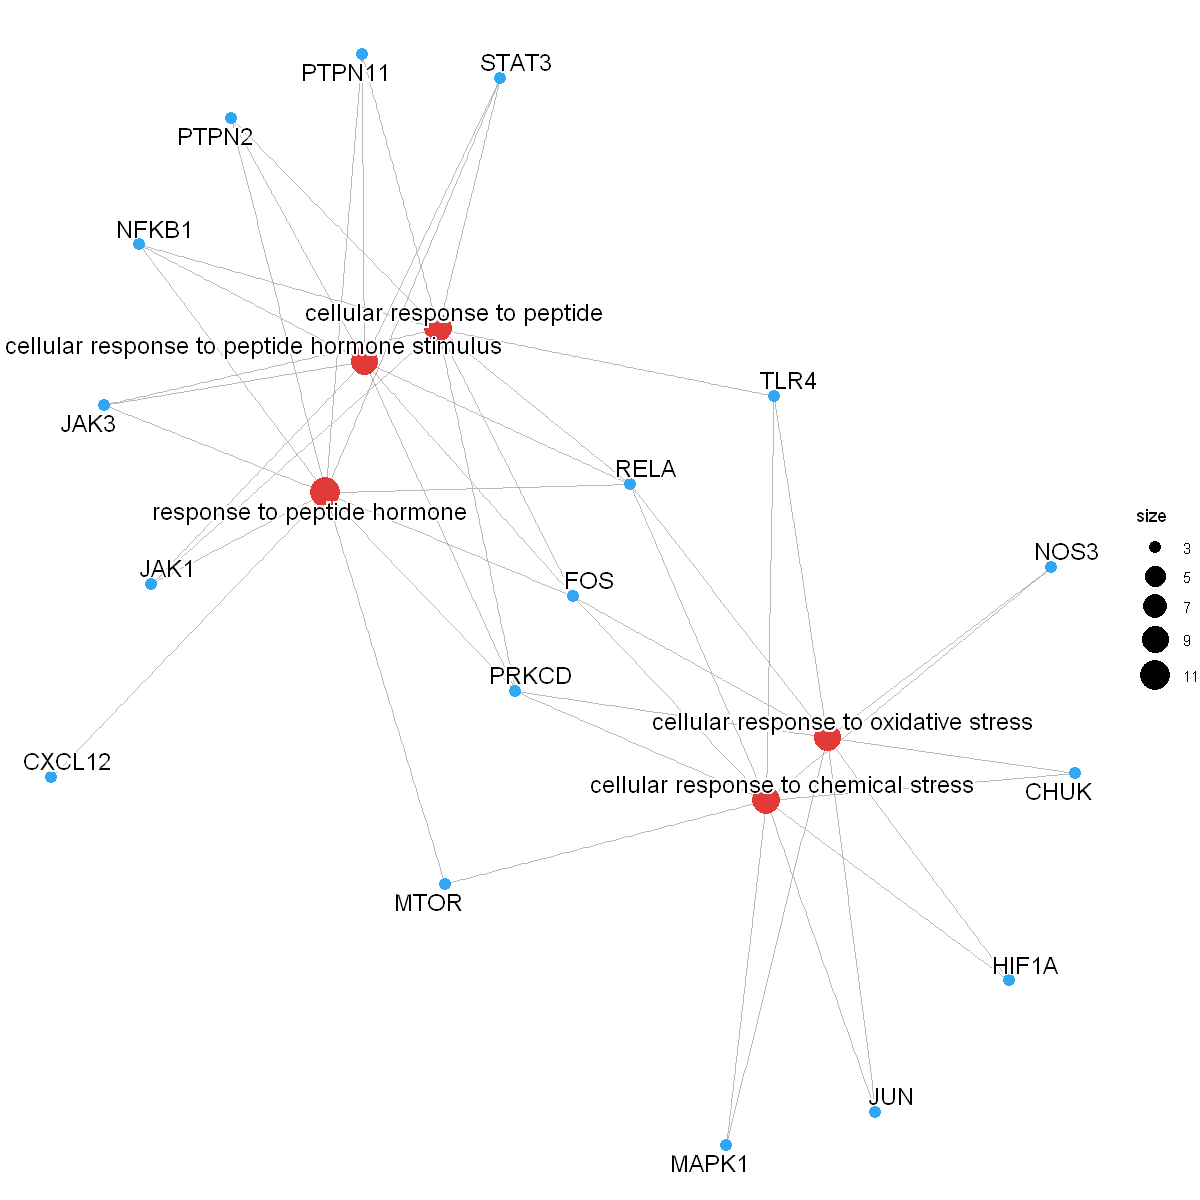

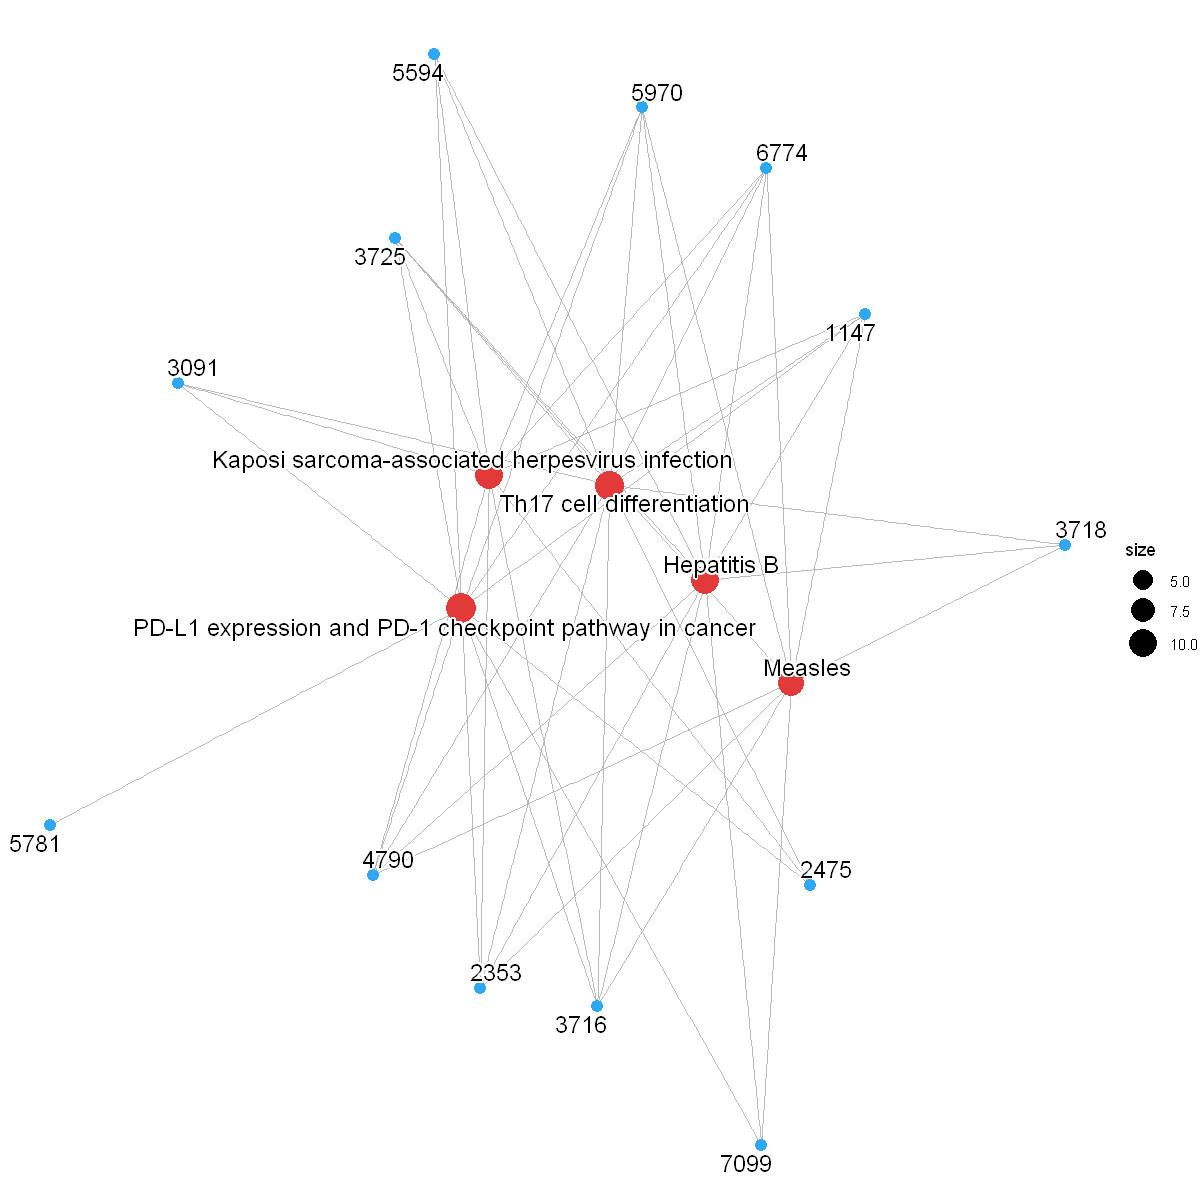

In [13]:
p5 <- enrichplot::cnetplot(GO, circular = FALSE, colorEdge = FALSE,
         shadowtext = "all",
         color.params = list(foldChange = NULL, edge = FALSE, category = "#e13a38", gene = "#2fa7f3"))
p6 <- enrichplot::cnetplot(KEGG, circular = FALSE, colorEdge = FALSE,
         shadowtext = "all",
         color.params = list(foldChange = NULL, edge = FALSE, category = "#e13a38", gene = "#2fa7f3"))
p5
p6

### 富集基因——所在功能集/通路集__关联热图

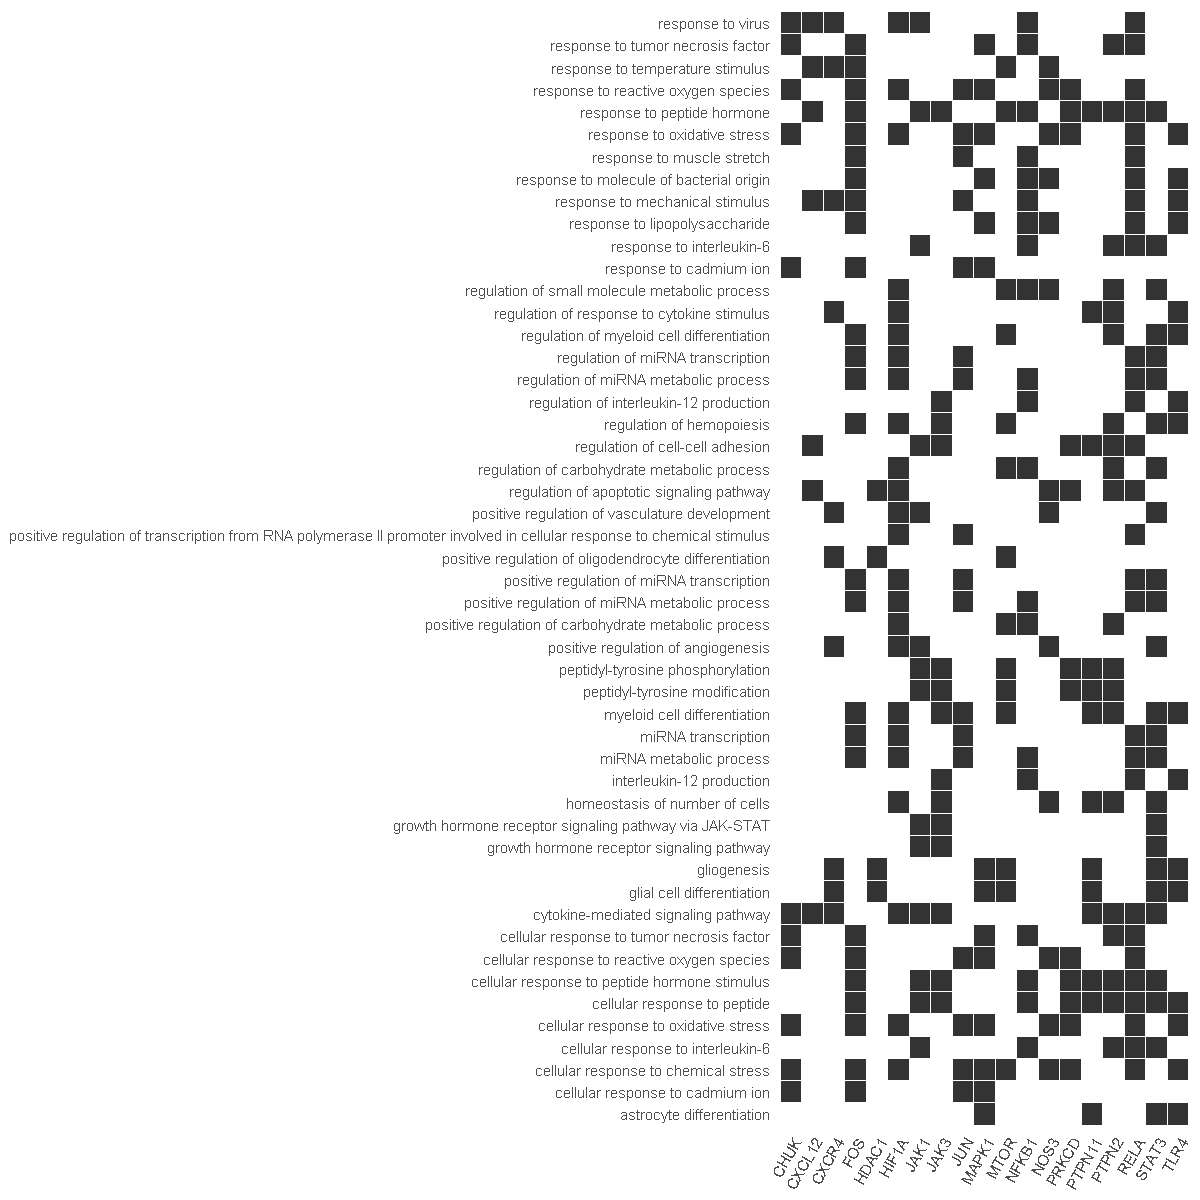

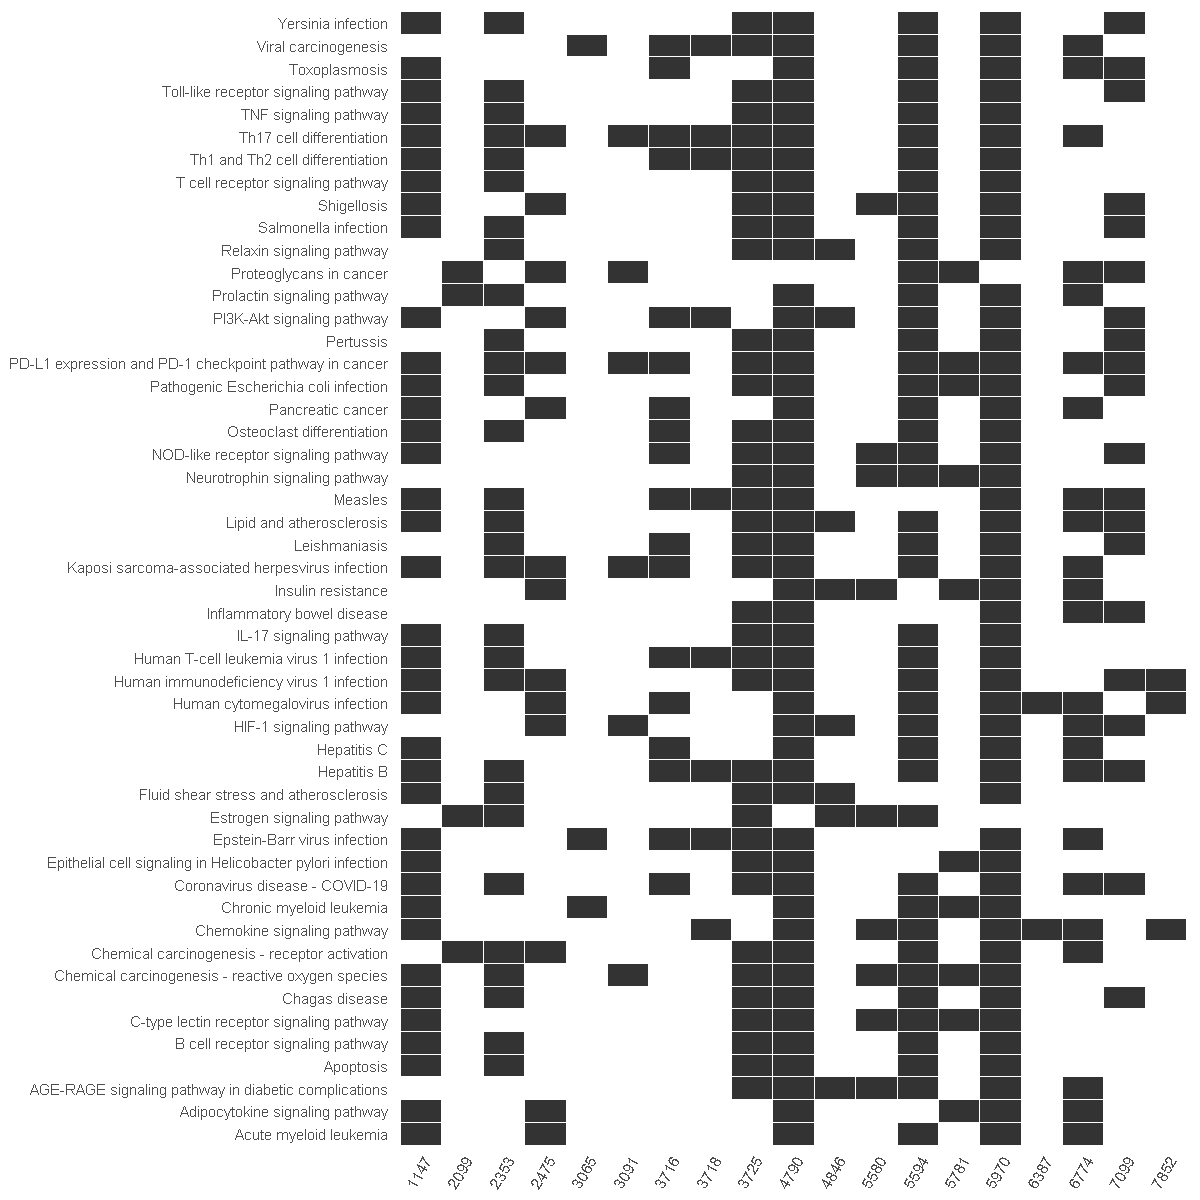

In [14]:
p7 <- enrichplot::heatplot(GO,showCategory = 50, label_format=150)#基因-通路关联热图
p8 <- enrichplot::heatplot(KEGG,showCategory = 50, label_format=150)
p7
p8

### 富集功能集/通路集之间__关联网络图

Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'layout.params = list(layout = your_value)' instead of 'layout'.
 The layout parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'layout.params = list(layout = your_value)' instead of 'layout'.
 The layout parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(category_label = your_value)' ins

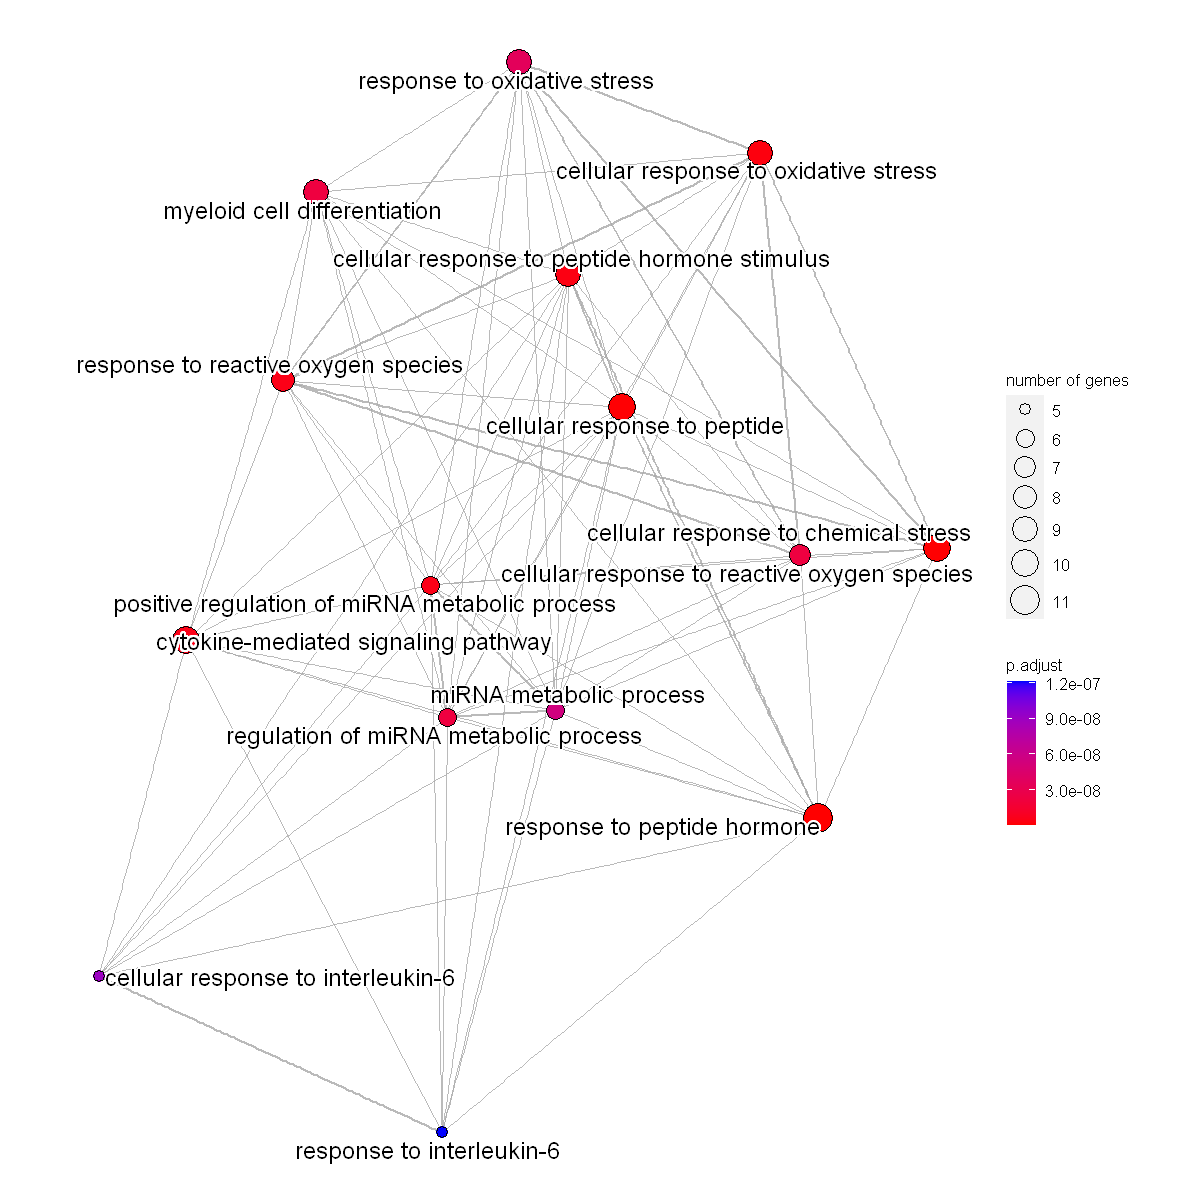

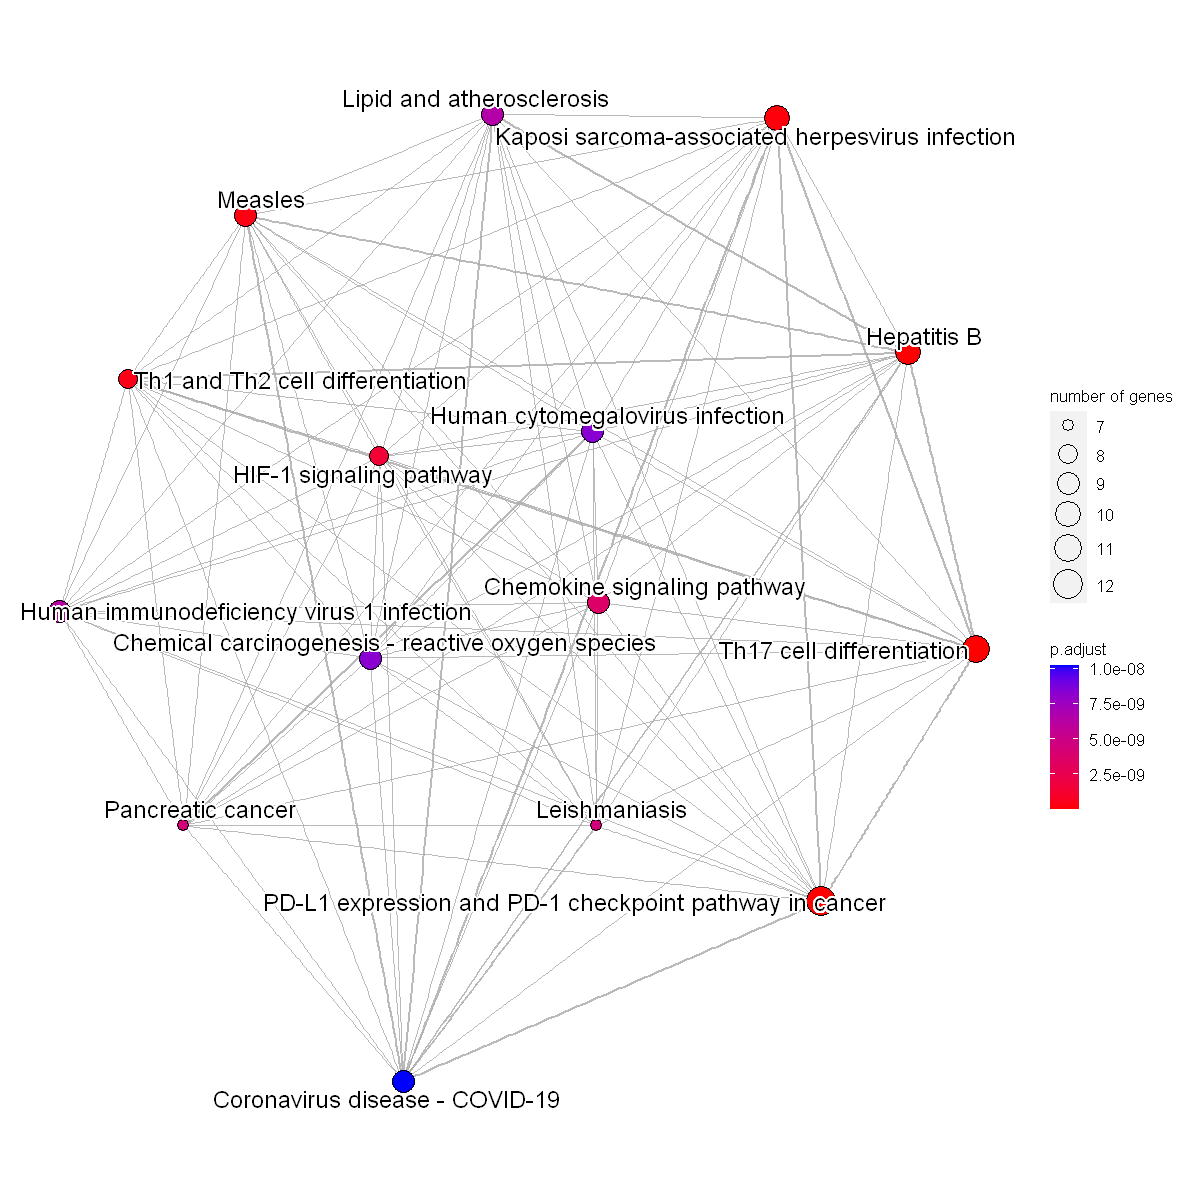

In [15]:
GO2 <- pairwise_termsim(GO)
KEGG2 <- pairwise_termsim(KEGG)
p9 <- enrichplot::emapplot(GO2,showCategory = 15, color = "p.adjust", layout = "kk", cex_label_category = 1, cex_line = 0.3)#通路间关联网络图
p10 <- enrichplot::emapplot(KEGG2,showCategory = 15, color = "p.adjust", layout = "kk", cex_label_category = 1, cex_line = 0.3)
p9
p10

### GO有向无环图（Directed Acyclic Graph，简称DAG）

In [ ]:
GO_BP<-enrichGO( gene$ENTREZID,#GO富集分析BP模块
                 OrgDb = GO_database,
                 keyType = "ENTREZID",
                 ont = "BP",
                 pvalueCutoff = 0.05,
                 pAdjustMethod = "BH",
                 qvalueCutoff = 0.05,
                 minGSSize = 10,
                 maxGSSize = 500,
                 readable = T)
p11 <- plotGOgraph(GO_BP)#GO-BP功能网络图
GO_CC<-enrichGO( gene$ENTREZID,#GO富集分析CC模块
                 OrgDb = GO_database,
                 keyType = "ENTREZID",
                 ont = "CC",
                 pvalueCutoff = 0.05,
                 pAdjustMethod = "BH",
                 qvalueCutoff = 0.05,
                 minGSSize = 10,
                 maxGSSize = 500,
                 readable = T)
p12 <- plotGOgraph(GO_CC)#GO-CC功能网络图
GO_MF<-enrichGO( gene$ENTREZID,#GO富集分析MF模块
                 OrgDb = GO_database,
                 keyType = "ENTREZID",
                 ont = "MF",
                 pvalueCutoff = 0.05,
                 pAdjustMethod = "BH",
                 qvalueCutoff = 0.05,
                 minGSSize = 10,
                 maxGSSize = 500,
                 readable = T)
p13 <- plotGOgraph(GO_MF)#GO-MF功能网络图
p11
p12
p13  

### 导出图片

In [16]:
output_dir <- "07_figure"
if (!dir.exists(output_dir)) {
  dir.create(output_dir)
}

# 设置画布宽度和高度（以英寸为单位）
width <- 10
height <- 10

# 保存GO柱状图
ggsave(file.path(output_dir, "GO_barplot.svg"), p1, device = "svg", width = width, height = height)

# 保存KEGG柱状图
ggsave(file.path(output_dir, "KEGG_barplot.svg"), p2, device = "svg", width = width, height = height)

# 保存GO点状图
ggsave(file.path(output_dir, "GO_dotplot.svg"), p3, device = "svg", width = width, height = height)

# 保存KEGG点状图
ggsave(file.path(output_dir, "KEGG_dotplot.svg"), p4, device = "svg", width = width, height = height)

ggsave(file.path(output_dir, "GO_cnetplot.svg"), p5, device = "svg", width = width, height = height)

ggsave(file.path(output_dir, "KEGG_cnetplot.svg"), p6, device = "svg", width = width, height = height)

ggsave(file.path(output_dir, "GO_heatplot.svg"), p7, device = "svg", width = width, height = height)

ggsave(file.path(output_dir, "KEGG_heatplot.svg"), p8, device = "svg", width = width, height = height)

ggsave(file.path(output_dir, "GO_emapplot.svg"), p9, device = "svg", width = width, height = height)

ggsave(file.path(output_dir, "KEGG_emapplot.svg"), p10, device = "svg", width = width, height = height)
